# Trabajo Final - Análisis de Datos

**Grupo:** Leandro Lepera, Mariano Campos, Ojeda Juan Cruz  
**Carrera:** 19Co2024 - CEIA  
**Materia:** Análisis de Datos  
**Tema asignado:** Meteorología en Argentina


## 1. Motivación

Para este trabajo final, se nos asignó el dataset relacionado con la **meteorología en Argentina**, con el objetivo de aplicar herramientas de análisis de datos para comprender mejor fenómenos climatológicos recientes y su comparación con patrones históricos.

Contamos con dos fuentes de información:
- Un registro **diario** de temperaturas del **último año**.
- Estadísticas **mensuales promedio** de los **últimos 30 años** (1991–2020).

A partir de estos datos, buscamos explorar posibles **cambios en los patrones climáticos** y evaluar **si se observan señales de cambio climático** en ciertas regiones del país. Algunas de las preguntas que nos guiarán incluyen:

- ¿Cómo se comparan las temperaturas del último año con los promedios históricos?
- ¿Existen estaciones del país donde las anomalías de temperatura sean más marcadas?
- ¿Qué meses del año presentan las mayores diferencias respecto de la media histórica?
- ¿Podemos encontrar una tendencia general al aumento de la temperatura?


## 2. Contexto y descripción del dataset

Para este trabajo se utilizan dos conjuntos de datos oficiales del **Servicio Meteorológico Nacional (SMN)** de Argentina, extraídos de su portal de datos abiertos.

### Dataset 1: Registro diario de temperaturas (último año)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Registros **diarios** de temperaturas mínimas y máximas correspondientes a múltiples estaciones meteorológicas distribuidas en el país.
- **Variables principales:** Fecha, nombre de la estación, provincia, temperatura mínima, temperatura máxima.
- **Periodo:** Últimos 365 días (a partir de la fecha de descarga).
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por día por estación.

### Dataset 2: Estadísticas normales (promedios 1991–2020)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Promedios **mensuales** de variables meteorológicas calculados sobre un periodo de 30 años (1991 a 2020), utilizados como referencia climática.
- **Variables principales:** Estación, variable medida (ej. temperatura mínima, temperatura máxima), y valores mensuales de enero a diciembre.
- **Periodo:** Promedios 1991–2020.
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por estación y por variable.

### Consideraciones

Ambos archivos fueron verificados con los docentes como los correspondientes al tema asignado. Durante el análisis, se realizarán transformaciones para adecuar los formatos (por ejemplo, pasar el segundo dataset a formato largo) y unificar criterios para permitir la comparación entre ambas fuentes.


In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## 2.1 Exploración y comprensión de los datos

En esta sección se describe la estructura general de los datasets, visualizando las primeras filas, tipos de datos y cantidad de registros. También se realiza una primera evaluación de valores faltantes y posibles inconsistencias.

---

### Dataset: registro_temperatura365d_smn

In [103]:
df_ly_raw = pd.read_fwf("registro_temperatura365d_smn.txt", skiprows=1, encoding="latin1") #La primera linea esta en blanco (skiprows=1)
print(f"Cantidad de filas: {df_ly_raw.shape[0]}")
print(f"Cantidad de columnas: {df_ly_raw.shape[1]}")

df_ly_raw.head()

Cantidad de filas: 42916
Cantidad de columnas: 4


,FECHA,TMAX,TMIN,NOMBRE
0,--------,-----,-----,----------------------------------------
1,30032025,28.9,21.4,AEROPARQUE AERO
2,30032025,23.0,13.7,AZUL AERO
3,30032025,22.6,14.6,BAHIA BLANCA AERO
4,30032025,12.6,4.4,BARILOCHE AERO


In [104]:
print('Nombres y tipos de columnas')
df_ly_raw.dtypes

Nombres y tipos de columnas


FECHA     object
TMAX      object
TMIN      object
NOMBRE    object
dtype: object

In [105]:
print('Cantidad de valores nulos por columna')
df_ly_raw.isnull().sum()

Cantidad de valores nulos por columna


FECHA        0
TMAX      4525
TMIN       620
NOMBRE       0
dtype: int64

Visualizando los valores nulos


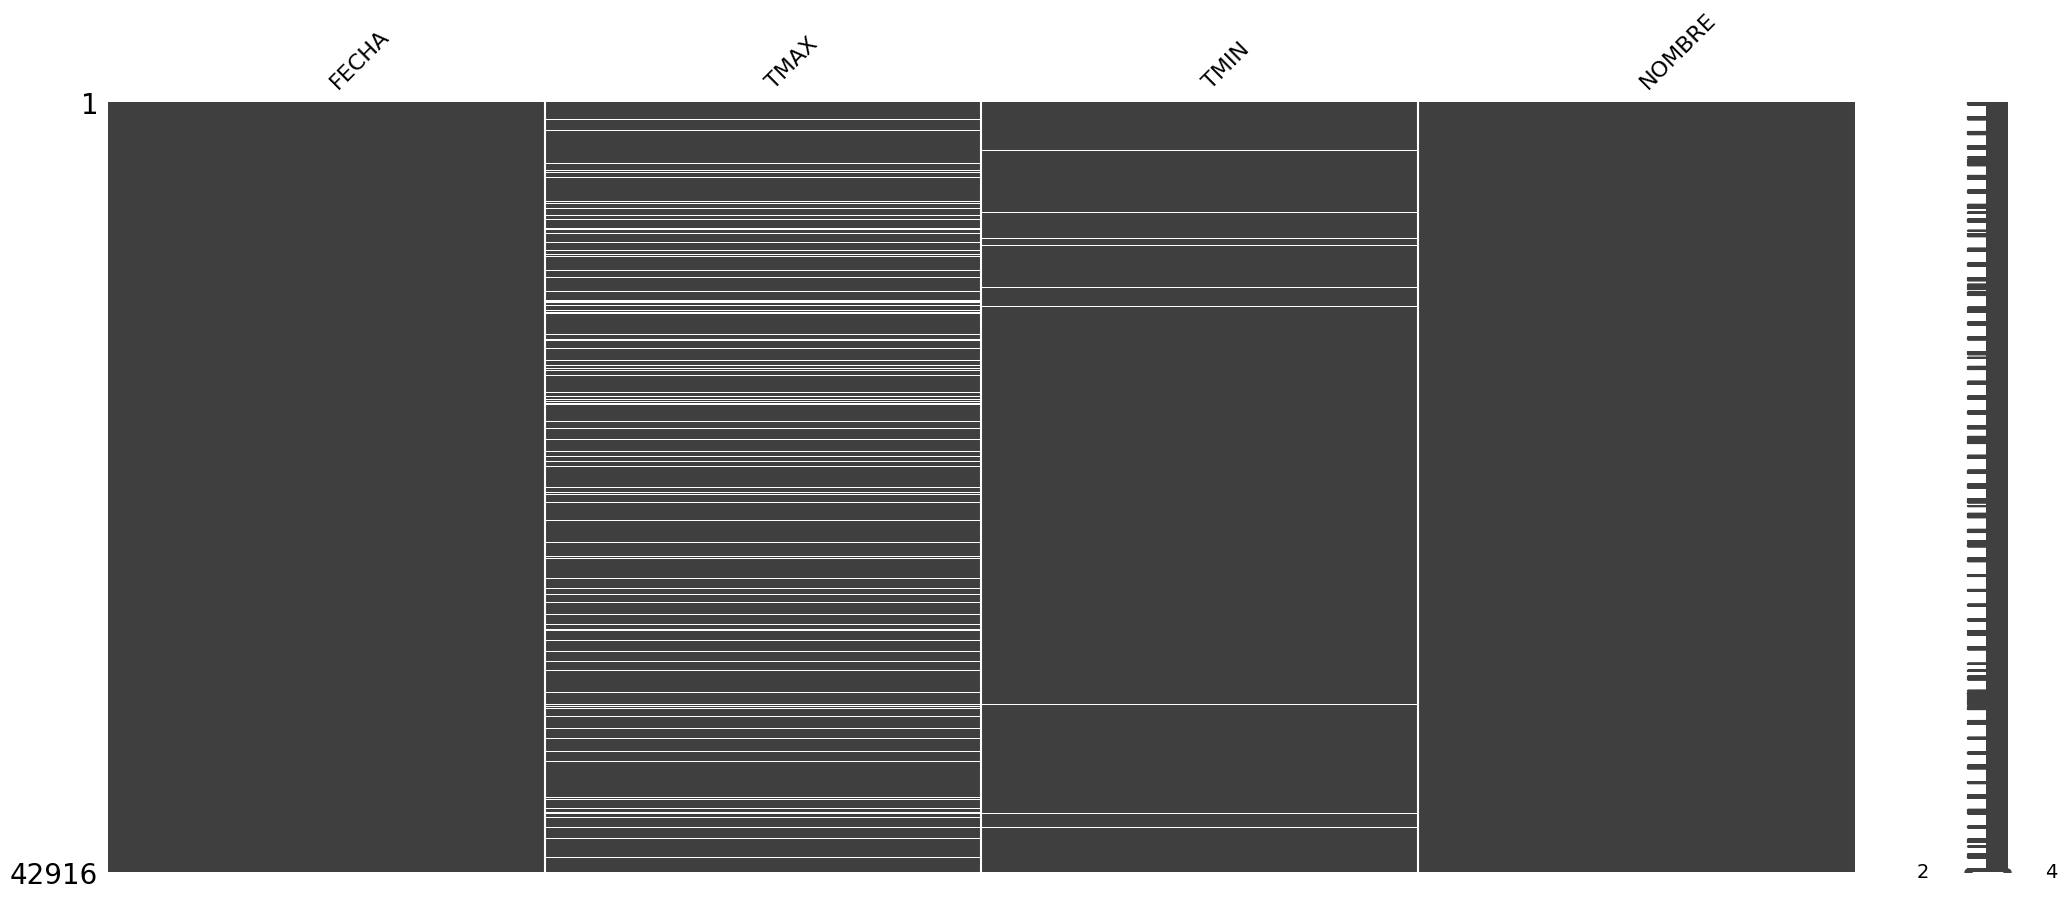

In [106]:
print('Visualizando los valores nulos')
msno.matrix(df_ly_raw);

In [107]:
print("Estaciones únicas:")
print(df_ly_raw['NOMBRE'].nunique())

Estaciones únicas:
119


A partir de la inspección inicial del dataset `df_ly_raw`, se observa lo siguiente:

- El dataset contiene una gran cantidad de filas (una por estación por día) y múltiples columnas, incluyendo fecha, temperaturas mínimas y máximas y nombre de la estación.
- Los nombres de columnas están en mayúsculas y el separador es por ancho fijo, ya que el archivo fue cargado con `read_fwf`.
- La columna `NOMBRE` representa la estación meteorológica, y hay múltiples estaciones distintas distribuidas en el país, con un total de 119.
- No hay una columna específica de provincia o ubicación geográfica, lo cual podría requerir un enriquecimiento posterior si se desea analizar por región.
- Algunas columnas tienen valores faltantes, especialmente en `TMAX` y `TMIN`, que se analizarán en profundidad en la etapa de limpieza.
- Las fechas están en formato de texto en esta etapa, y se convertirán en tipo fecha (`datetime`) más adelante.

Esta exploración inicial permite comprender la estructura general del dataset, detectar posibles inconsistencias, y planificar las transformaciones necesarias para el análisis.


### Dataset: Estadísticas normales Datos abiertos 1991-2020

## 2.2 Aplicación de técnicas de visualización

Se aplican herramientas gráficas como histogramas, boxplots, líneas de tiempo y otros para explorar el comportamiento de las variables principales y detectar patrones, estacionalidades o valores atípicos.

---

### Dataset: registro_temperatura365d_smn

In [108]:
df_ly = df_ly_raw.copy() # Copia del dataframe original

# Quitar filas que no tengan una fecha válida (por ejemplo, si tienen guiones)
df_ly = df_ly[df_ly['FECHA'].str.fullmatch(r"\d{8}")] # Filtrar fechas con formato de 8 dígitos (día-mes-año) 

df_ly['FECHA'] = pd.to_datetime(df_ly['FECHA'], format = '%d%m%Y') # Convertir a fecha con formato día-mes-año
df_ly['TMAX'] = pd.to_numeric(df_ly['TMAX'], errors='coerce') # Ignorar errores de conversión a numérico (por ejemplo, guiones)
df_ly['TMIN'] = pd.to_numeric(df_ly['TMIN'], errors='coerce') # Ignorar errores de conversión a numérico (por ejemplo, guiones)
df_ly['NOMBRE'] = df_ly['NOMBRE'].astype('category') # Convertir a categoría

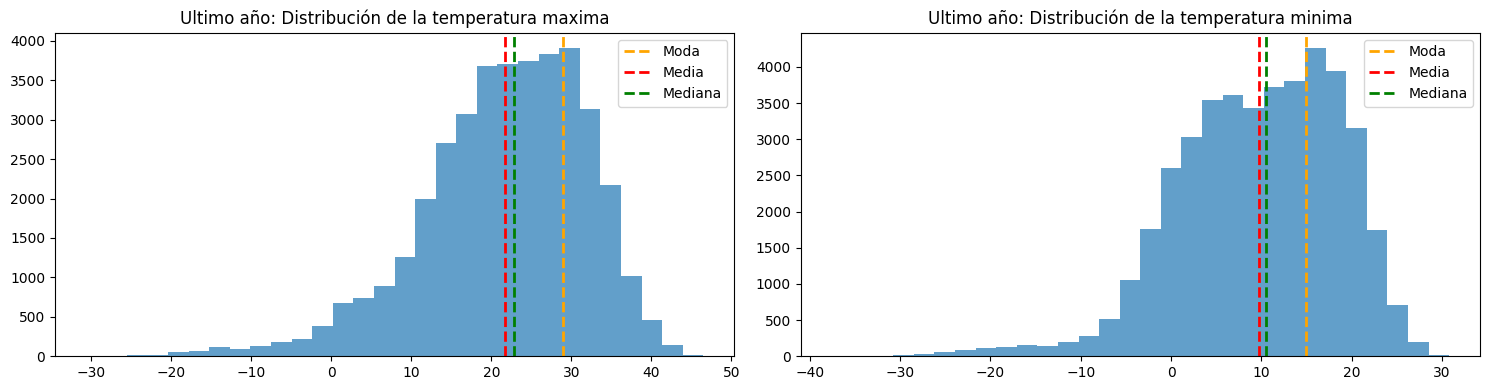

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Función para graficar
def plot_distribution(ax, data, title):
    ax.hist(data, bins=30, alpha=0.7) # dibujar histograma
    ax.axvline(data.mode()[0], color='orange', linestyle='dashed', linewidth=2, label='Moda') # dibujar la moda
    ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2, label='Media') # dibujar la media
    ax.axvline(data.median(), color='green', linestyle='dashed', linewidth=2, label='Mediana') # dibujar la mediana
    ax.set_title(title)
    ax.legend()

plot_distribution(axes[0], df_ly['TMAX'], 'Ultimo año: Distribución de la temperatura maxima')
plot_distribution(axes[1], df_ly['TMIN'], 'Ultimo año: Distribución de la temperatura minima')
#plot_distribution(axes[2], df['sibsp'], 'Titanic: Distribución familiares (SibSp)')

plt.tight_layout()
plt.show()

Se observan las distribuciones de temperaturas máximas y mínimas durante el último año. Las líneas verticales indican la moda (naranja), media (roja) y mediana (verde), lo que permite detectar asimetrías y valores típicos. La distribución es esperablemente amplia, dada la diversidad climática del país.

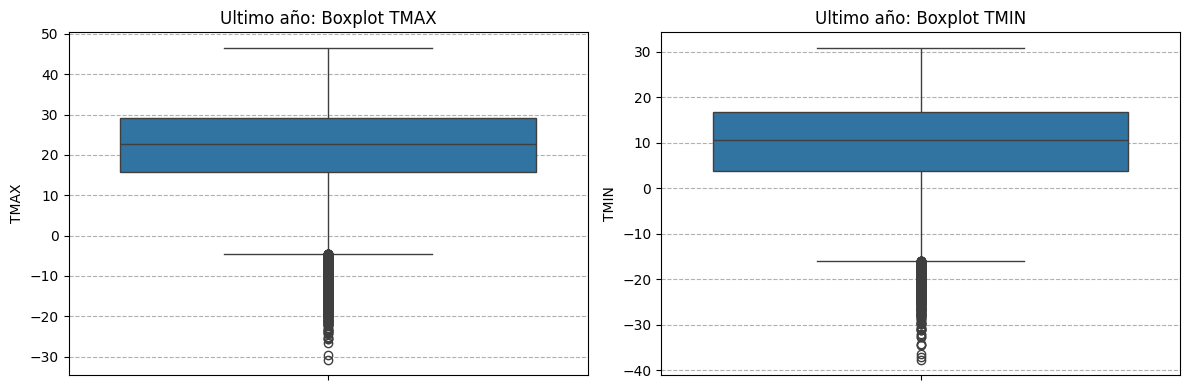

In [110]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

# ejemplo:
sns.boxplot(data=df_ly, y='TMAX', ax=ax[0])
sns.boxplot(data=df_ly, y='TMIN', ax=ax[1])

ax[0].grid(axis='y', ls='--')
ax[1].grid(axis='y', ls='--')
ax[0].set_title('Ultimo año: Boxplot TMAX')
ax[1].set_title('Ultimo año: Boxplot TMIN')

plt.tight_layout()
plt.show()

Los boxplots muestran la dispersión y los outliers en las temperaturas extremas. La presencia de valores atípicos es esperable debido a la inclusión de estaciones ubicadas en zonas con climas extremos (como la Base Marambio en la Antártida). No se eliminarán ya que representan fenómenos reales.

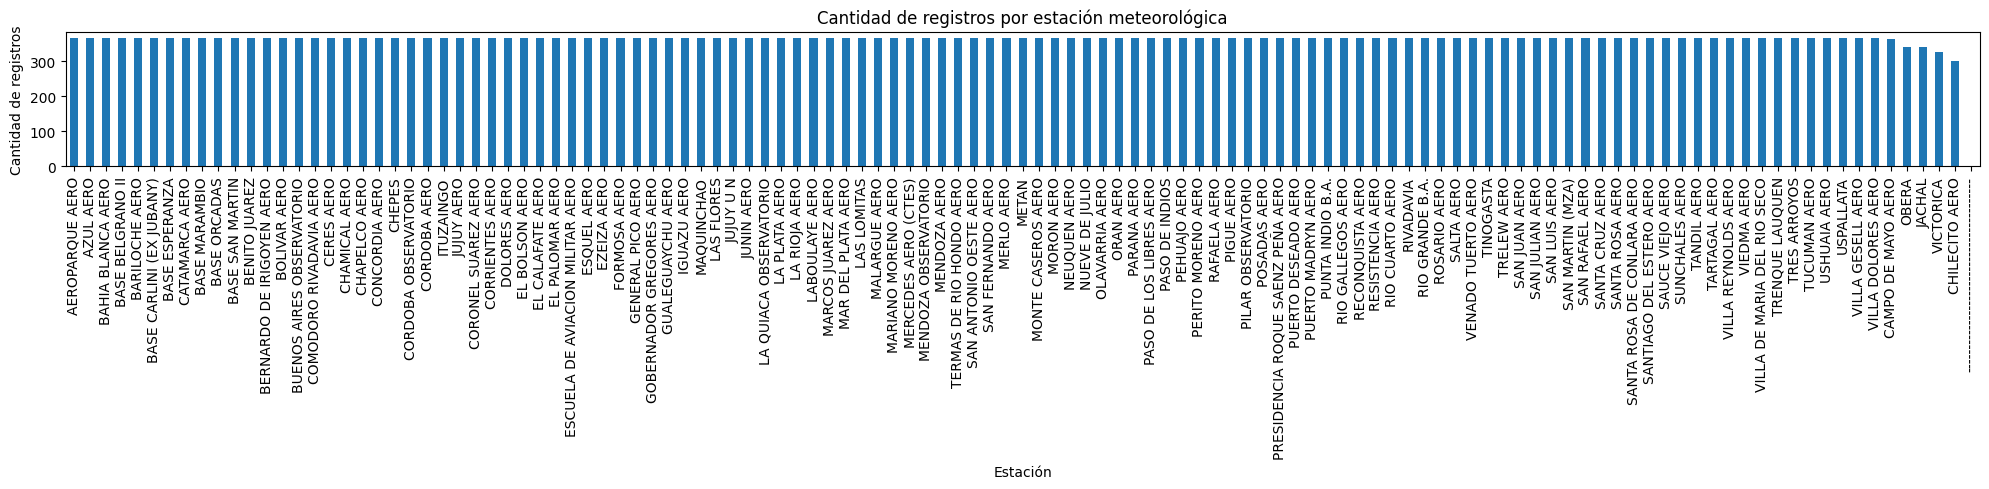

In [111]:
conteo = df_ly_raw['NOMBRE'].value_counts()

plt.figure(figsize=(20,5))
conteo.plot(kind='bar')
plt.title('Cantidad de registros por estación meteorológica')
plt.xlabel('Estación')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Aquí se muestra cuántos registros tiene cada estación meteorológica en el dataset. Algunas estaciones tienen menos de 365 registros, indicando posibles faltantes de datos o cortes en la recolección.

C:\Users\Juan\AppData\Local\Temp\ipykernel_19776\3668180416.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incompletas = df_ly.groupby('NOMBRE').size()


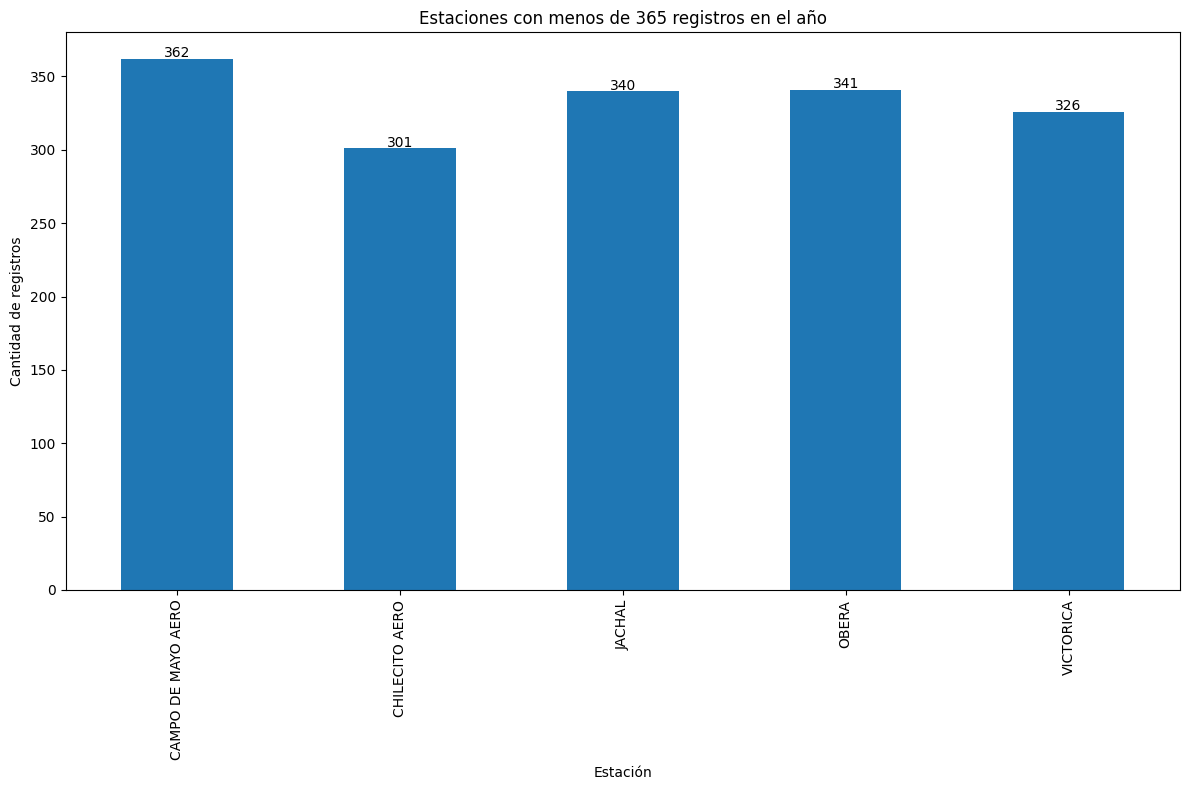

In [112]:
incompletas = df_ly.groupby('NOMBRE').size()
incompletas = incompletas[incompletas < 365]

plt.figure(figsize=(12,8))
ax = incompletas.plot(kind='bar')
plt.title('Estaciones con menos de 365 registros en el año')
plt.xlabel('Estación')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)

# Agregar valor encima de cada barra
for i, valor in enumerate(incompletas):
    plt.text(x=i, y=valor + 1, s=str(valor), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Este gráfico enfoca exclusivamente en las estaciones que tienen datos incompletos (menos de 365 días registrados). Las barras más bajas indican estaciones con mayor cantidad de días faltantes. Esto permite detectar posibles problemas de cobertura o interrupciones en la recolección de datos.

### Dataset: Estadísticas normales Datos abiertos 1991-2020

## 2.3 Limpieza del dataset

Aquí se aplican técnicas para tratar valores nulos, inconsistencias, tipos incorrectos o datos duplicados. Se definen reglas de limpieza y se transforman columnas para facilitar el análisis posterior.

---

### Dataset: registro_temperatura365d_smn

En esta etapa se completan las tareas de limpieza del dataset `df_ly`, que fue creado previamente como copia del original (`df_ly_raw`).

- Se eliminaron filas con fechas inválidas, conservando únicamente aquellas con formato numérico de 8 dígitos (DDMMAAAA).
- Se convirtieron las columnas `TMAX` y `TMIN` a tipo numérico, generando valores `NaN` en aquellas celdas que contenían guiones u otros valores no interpretables como números.
- La columna `FECHA` se transformó a tipo `datetime` para facilitar operaciones temporales.
- Se detectaron valores faltantes (`NaN`) en las columnas de temperatura. Se considera que estos valores son del tipo **MAR (Missing At Random)**, ya que suelen depender de la estación meteorológica y no del valor ausente en sí.

Tratamiento de datos faltantes

Como estrategia de imputación, se propone rellenar los valores faltantes con la **temperatura promedio mensual de la misma estación**, ya que esto respeta la variabilidad estacional y regional de los datos.

La limpieza realizada garantiza que los datos estén en formato coherente y listos para la transformación y extracción de nuevas variables.


C:\Users\Juan\AppData\Local\Temp\ipykernel_19776\2236501717.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ly[col] = df_ly.groupby(['NOMBRE', 'MES'])[col].transform(lambda x: x.fillna(x.mean()))
C:\Users\Juan\AppData\Local\Temp\ipykernel_19776\2236501717.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ly[col] = df_ly.groupby('NOMBRE')[col].transform(lambda x: x.fillna(x.mean()))


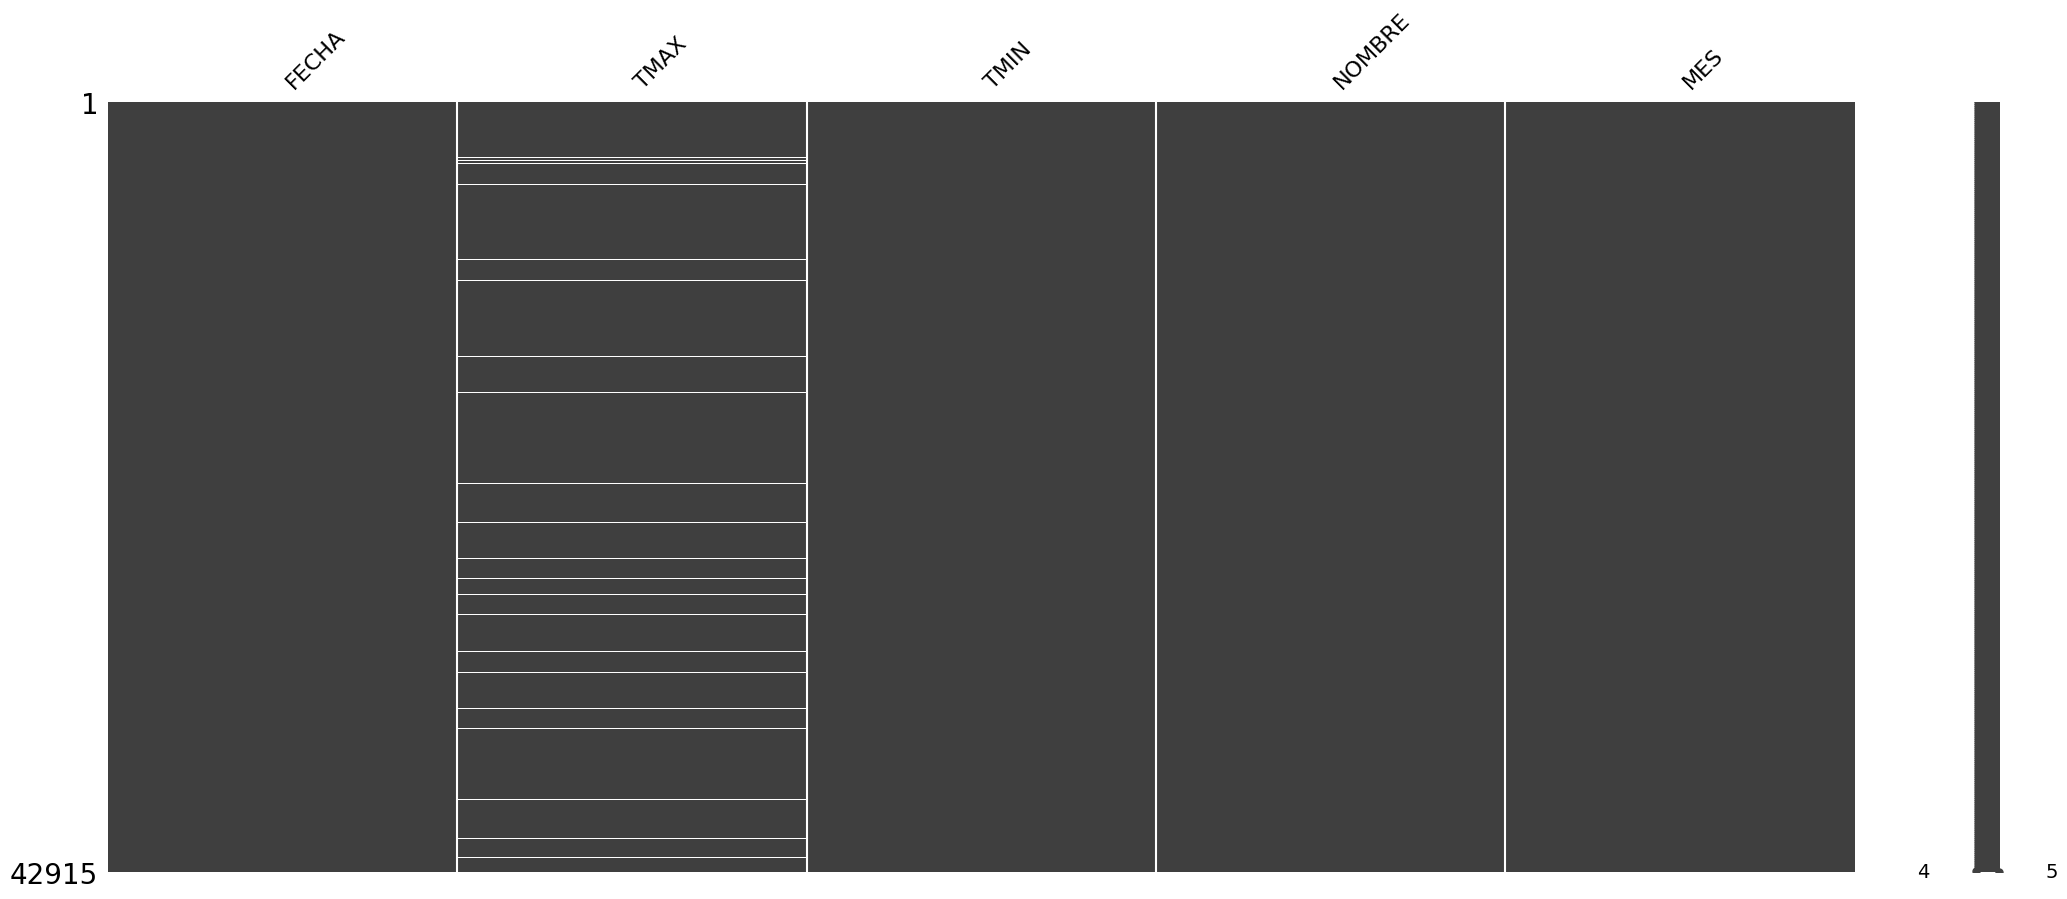

In [113]:
# Agregar columna auxiliar del mes
df_ly['MES'] = df_ly['FECHA'].dt.month

# Imputación en dos pasos: mensual por estación → anual por estación
for col in ['TMAX', 'TMIN']:
    # Paso 1: promedio mensual por estación
    df_ly[col] = df_ly.groupby(['NOMBRE', 'MES'])[col].transform(lambda x: x.fillna(x.mean()))
    # Paso 2: si aún quedan NaNs, usar promedio anual por estación
    df_ly[col] = df_ly.groupby('NOMBRE')[col].transform(lambda x: x.fillna(x.mean()))


msno.matrix(df_ly);

In [114]:
print('Cantidad de valores nulos por columna')
df_ly.isnull().sum()

Cantidad de valores nulos por columna


FECHA        0
TMAX      1095
TMIN         0
NOMBRE       0
MES          0
dtype: int64

In [115]:
# Ver qué combinaciones de NOMBRE y MES tienen todas las TMAX en NaN
faltantes_graves = df_ly.groupby(['NOMBRE', 'MES'])['TMAX'].apply(lambda x: x.isna().all())
faltantes_graves = faltantes_graves.fillna(False)  # ← esto evita el error
faltantes_graves[faltantes_graves].index.tolist()


C:\Users\Juan\AppData\Local\Temp\ipykernel_19776\3557547445.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_graves = df_ly.groupby(['NOMBRE', 'MES'])['TMAX'].apply(lambda x: x.isna().all())
C:\Users\Juan\AppData\Local\Temp\ipykernel_19776\3557547445.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  faltantes_graves = faltantes_graves.fillna(False)  # ← esto evita el error


[('CHAMICAL AERO', 1),
 ('CHAMICAL AERO', 2),
 ('CHAMICAL AERO', 3),
 ('CHAMICAL AERO', 4),
 ('CHAMICAL AERO', 5),
 ('CHAMICAL AERO', 6),
 ('CHAMICAL AERO', 7),
 ('CHAMICAL AERO', 8),
 ('CHAMICAL AERO', 9),
 ('CHAMICAL AERO', 10),
 ('CHAMICAL AERO', 11),
 ('CHAMICAL AERO', 12),
 ('ESCUELA DE AVIACION MILITAR AERO', 1),
 ('ESCUELA DE AVIACION MILITAR AERO', 2),
 ('ESCUELA DE AVIACION MILITAR AERO', 3),
 ('ESCUELA DE AVIACION MILITAR AERO', 4),
 ('ESCUELA DE AVIACION MILITAR AERO', 5),
 ('ESCUELA DE AVIACION MILITAR AERO', 6),
 ('ESCUELA DE AVIACION MILITAR AERO', 7),
 ('ESCUELA DE AVIACION MILITAR AERO', 8),
 ('ESCUELA DE AVIACION MILITAR AERO', 9),
 ('ESCUELA DE AVIACION MILITAR AERO', 10),
 ('ESCUELA DE AVIACION MILITAR AERO', 11),
 ('ESCUELA DE AVIACION MILITAR AERO', 12),
 ('RIO CUARTO AERO', 1),
 ('RIO CUARTO AERO', 2),
 ('RIO CUARTO AERO', 3),
 ('RIO CUARTO AERO', 4),
 ('RIO CUARTO AERO', 5),
 ('RIO CUARTO AERO', 6),
 ('RIO CUARTO AERO', 7),
 ('RIO CUARTO AERO', 8),
 ('RIO CUARTO 

In [116]:
estaciones_sin_tmax = df_ly.groupby('NOMBRE')['TMAX'].apply(lambda x: x.isna().all())
estaciones_sin_tmax[estaciones_sin_tmax].index.tolist()


C:\Users\Juan\AppData\Local\Temp\ipykernel_19776\737611211.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estaciones_sin_tmax = df_ly.groupby('NOMBRE')['TMAX'].apply(lambda x: x.isna().all())


['CHAMICAL AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'RIO CUARTO AERO']

Al analizar los valores faltantes de la variable `TMAX`, se detectó que los más de 1000 valores ausentes se concentran exclusivamente en tres estaciones meteorológicas:

- CHAMICAL AERO  
- ESCUELA DE AVIACION MILITAR AERO  
- RIO CUARTO AERO

Esto indica que los faltantes no se distribuyen aleatoriamente, ni responden a condiciones estacionales, sino que afectan de forma sistemática a ciertos puntos de medición. En este contexto, se clasifican como **faltantes del tipo MNAR (Missing Not At Random)**, ya que su aparición depende de la estación y no del valor ausente.

Dado que estas estaciones no cuentan con información suficiente para una imputación fiable, se optará por excluirlas del análisis posterior para evitar sesgos artificiales en los resultados.


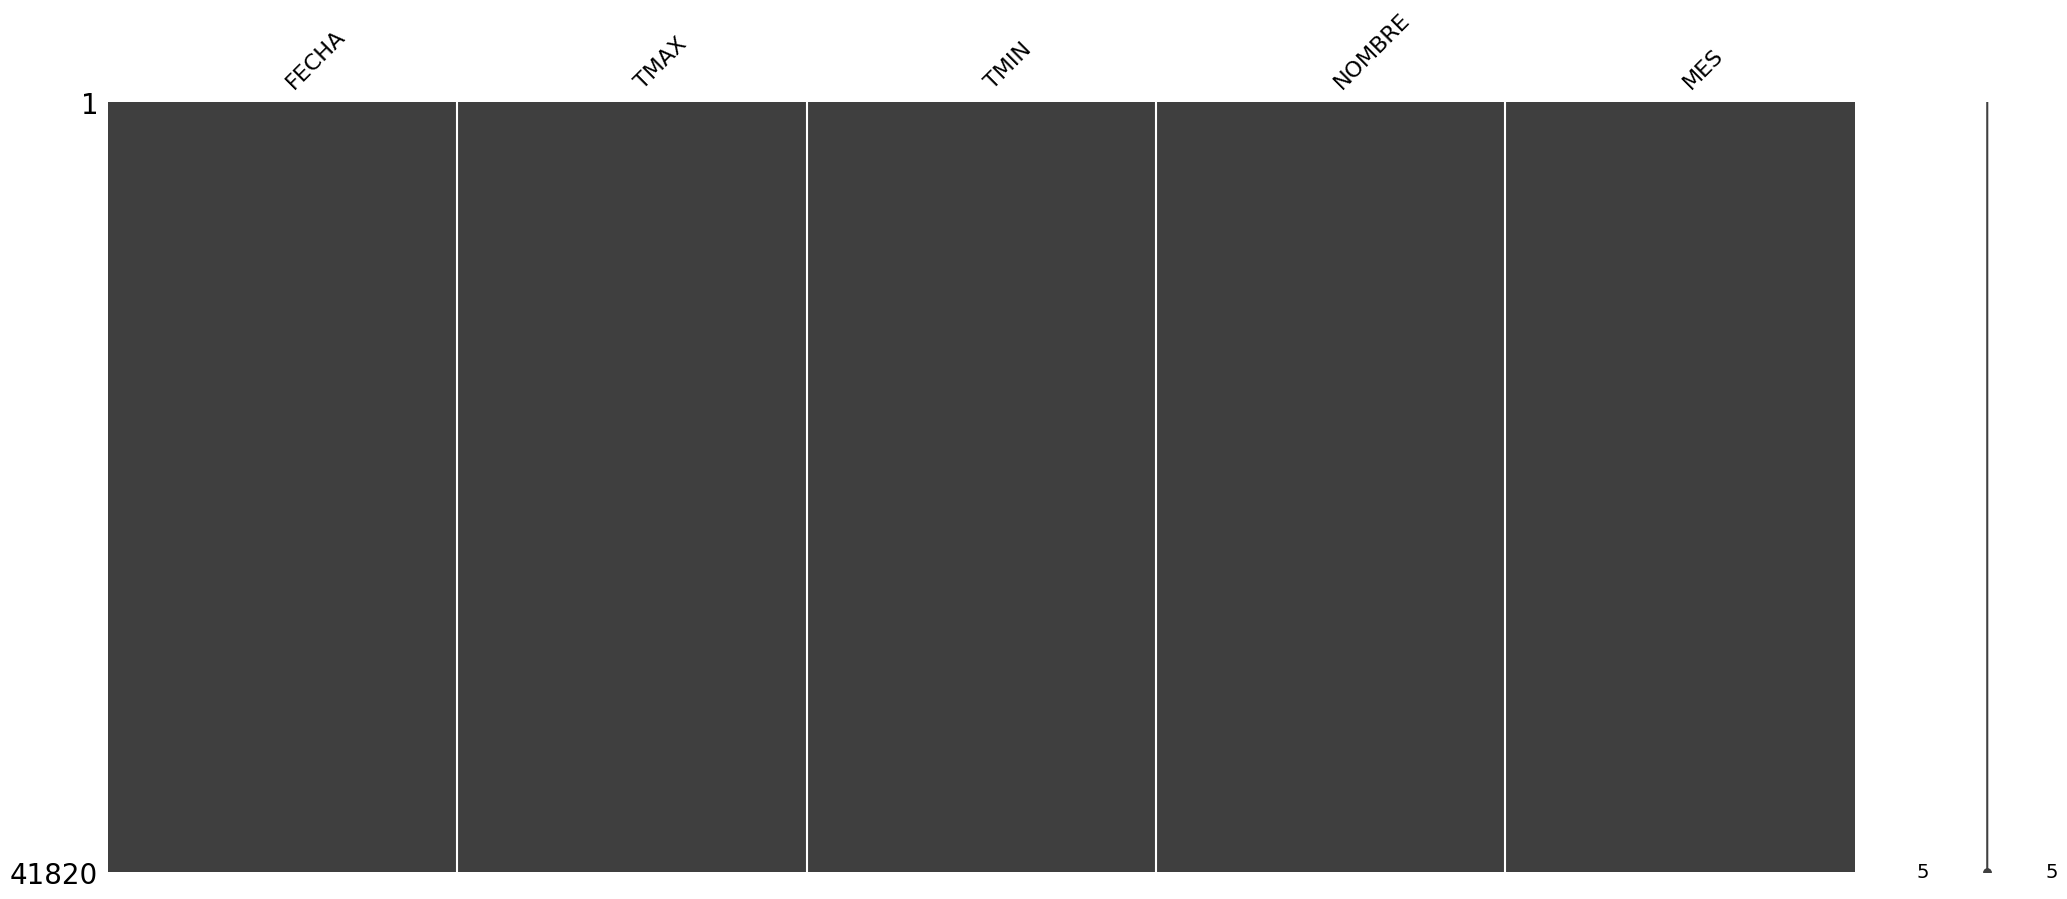

In [117]:
# Estaciones con todos los TMAX ausentes
estaciones_excluir = ['CHAMICAL AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'RIO CUARTO AERO']
df_ly = df_ly[~df_ly['NOMBRE'].isin(estaciones_excluir)]

msno.matrix(df_ly);

### Dataset: Estadísticas normales Datos abiertos 1991-2020

## 2.4 Transformación de variables y selección de features

Se transforman variables según sea necesario (por ejemplo, crear una temperatura media entre TMAX y TMIN, extraer mes o estación del año desde la fecha, etc.). También se seleccionan las variables más relevantes para el análisis.

---

En esta sección se crean nuevas variables derivadas del dataset original con el objetivo de facilitar el análisis y la construcción de posibles modelos. Estas transformaciones permiten simplificar el comportamiento de ciertas variables, capturar tendencias temporales y reducir la complejidad del dataset sin perder información relevante.


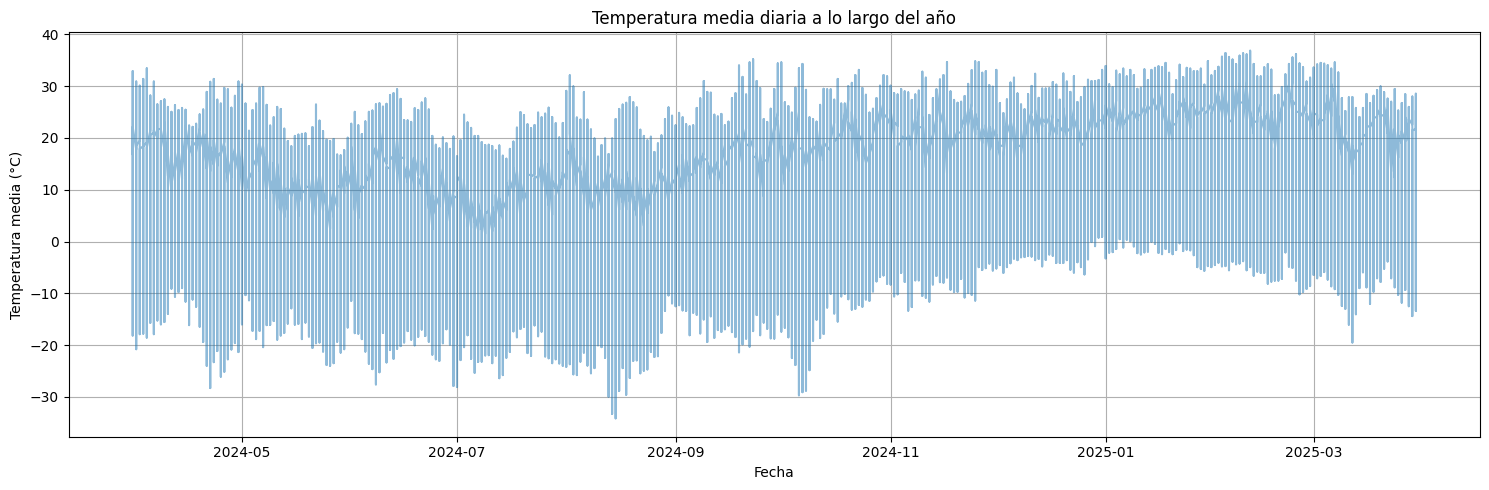

In [120]:
df_ly['TEMP_MEDIA'] = (df_ly['TMAX'] + df_ly['TMIN']) / 2

plt.figure(figsize=(15,5))
plt.plot(df_ly['FECHA'], df_ly['TEMP_MEDIA'], alpha=0.5)
plt.title('Temperatura media diaria a lo largo del año')
plt.xlabel('Fecha')
plt.ylabel('Temperatura media (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico permite observar la evolución de la temperatura media diaria a lo largo del año. Se visualiza una estacionalidad clara con máximos en verano y mínimos en invierno, como es característico en el hemisferio sur.

In [124]:
# Leemos el archivo CSV con las regiones y creamos un diccionario para mapear las estaciones a sus regiones
df_regiones = pd.read_csv("estaciones_con_regiones.csv")
mapa_regiones = dict(zip(df_regiones["NOMBRE"], df_regiones["REGION"]))
df_ly["REGION"] = df_ly["NOMBRE"].map(mapa_regiones)

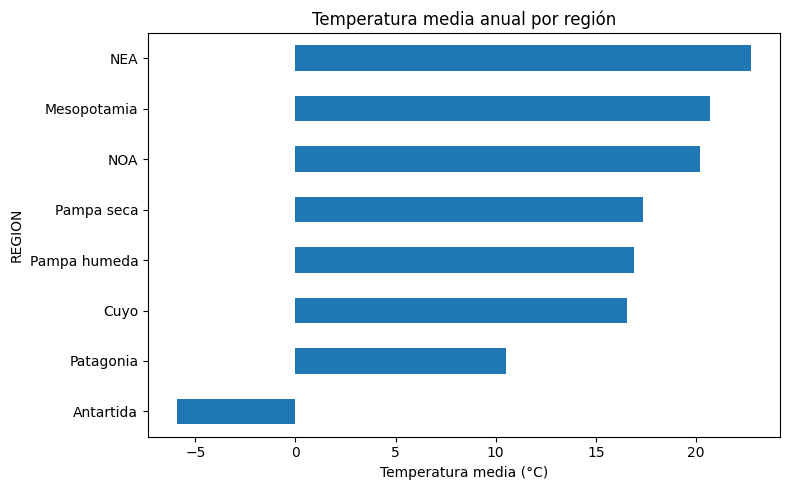

In [121]:
# Agrupar por región y calcular media
media_por_region = df_ly.groupby('REGION')['TEMP_MEDIA'].mean().sort_values()

# Gráfico de barras horizontales
media_por_region.plot(kind='barh', figsize=(8, 5), title='Temperatura media anual por región')
plt.xlabel('Temperatura media (°C)')
plt.tight_layout()
plt.show()


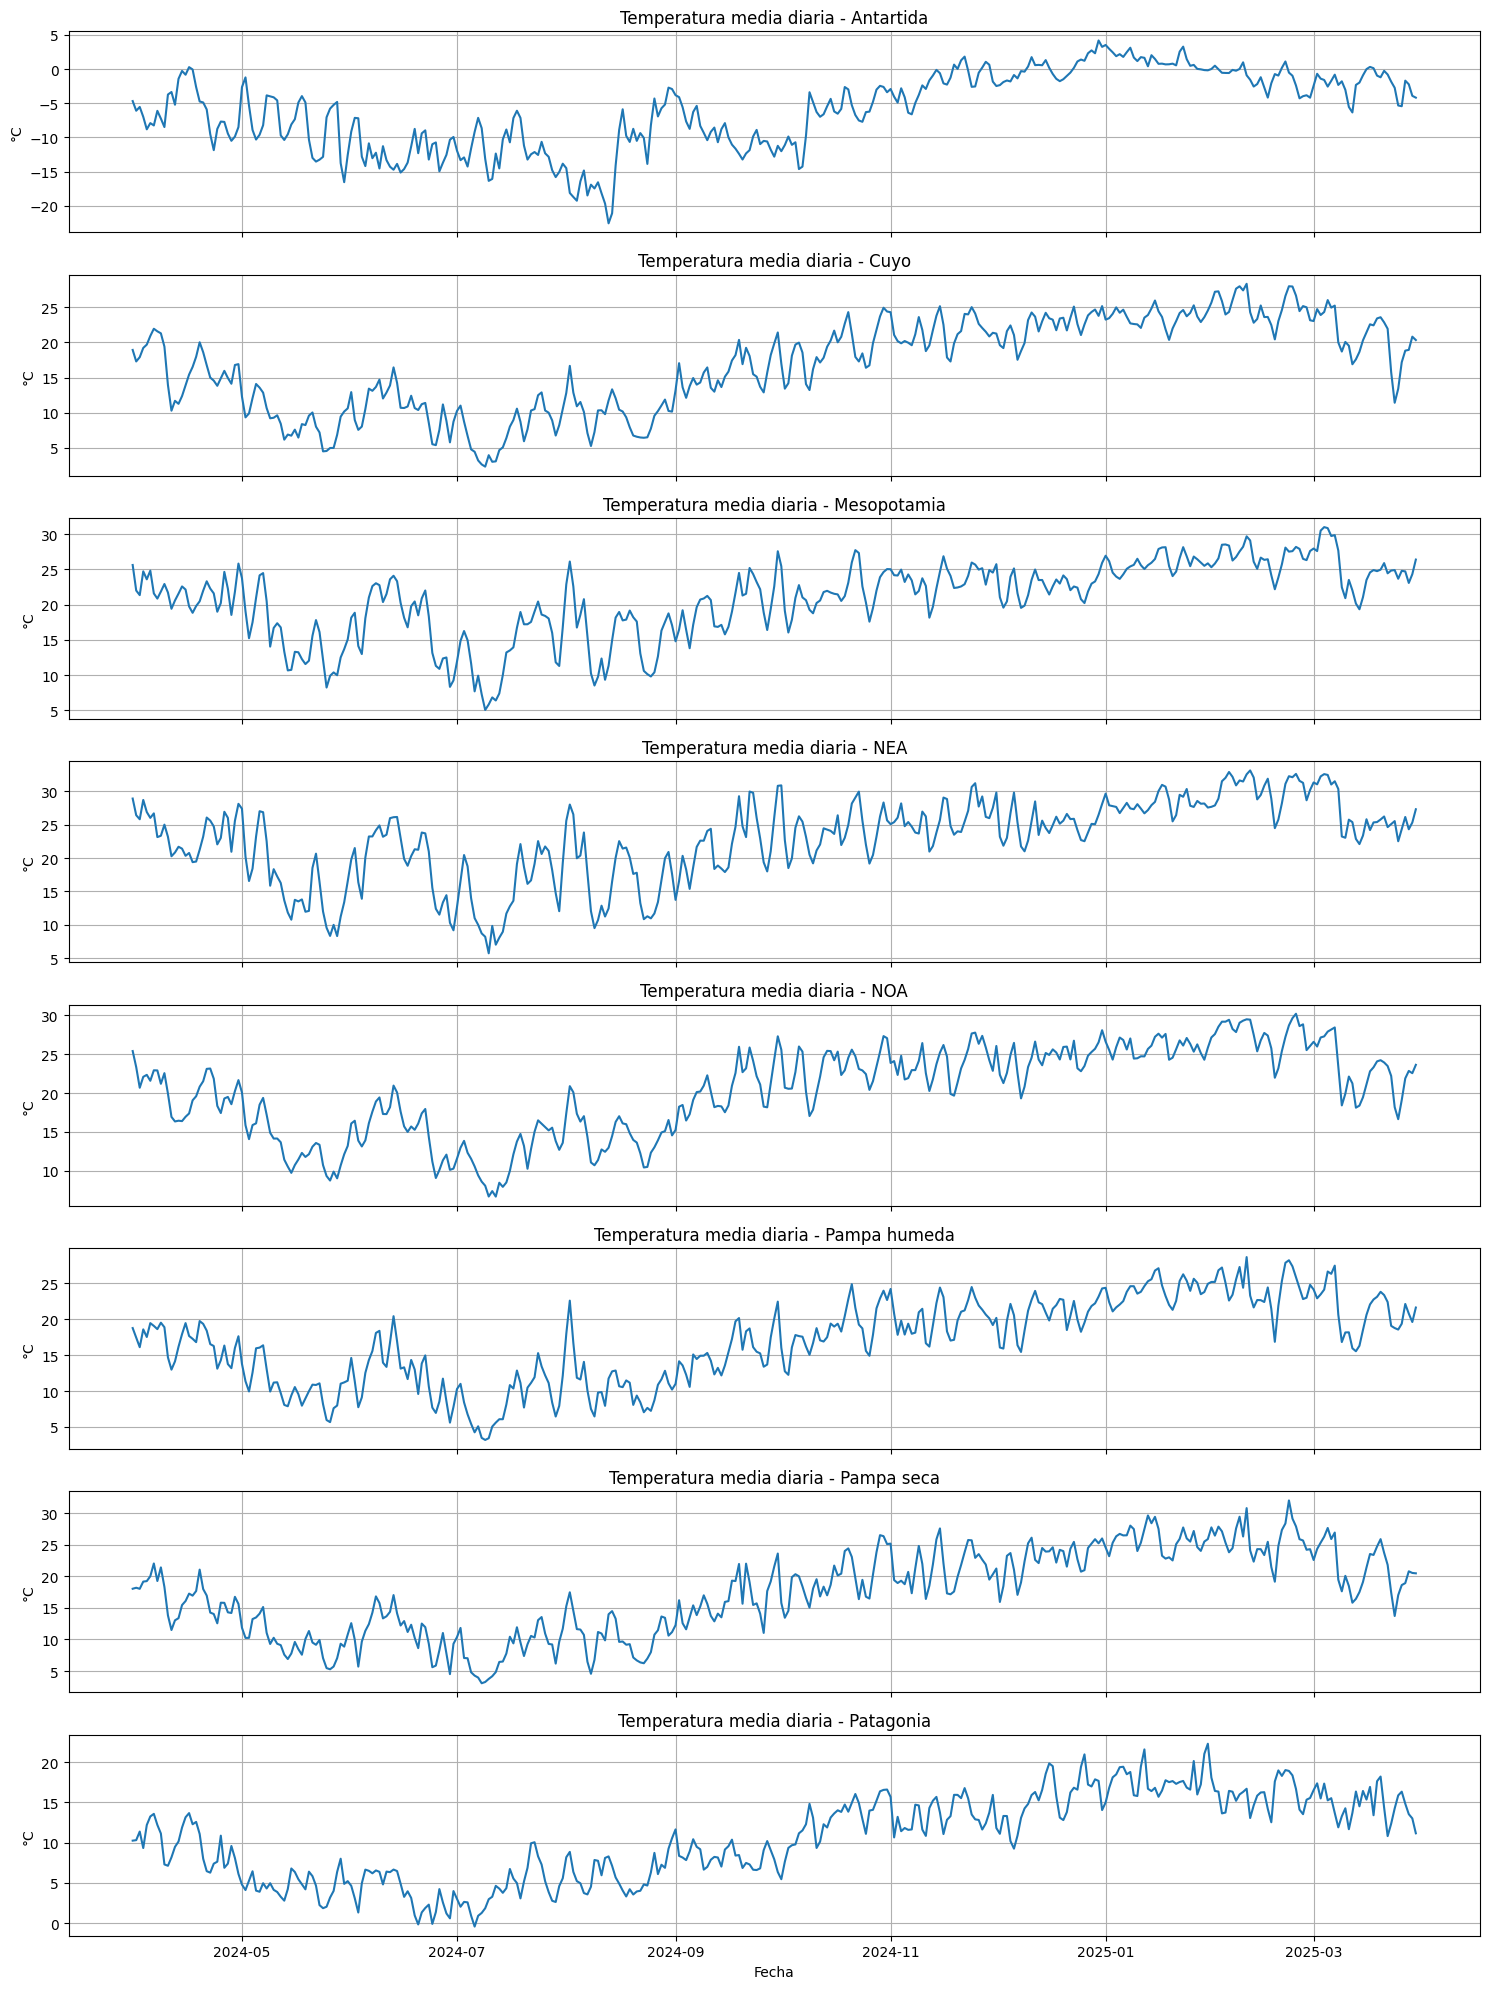

In [123]:
# Ordenamos por fecha por seguridad
df_ly = df_ly.sort_values('FECHA')

# Agrupamos por región
regiones = df_ly['REGION'].dropna().unique()
n = len(regiones)

# Creamos los subplots
fig, axes = plt.subplots(n, 1, figsize=(15, 2.5 * n), sharex=True)

for i, region in enumerate(sorted(regiones)):
    ax = axes[i]
    subset = df_ly[df_ly['REGION'] == region]
    media_diaria = subset.groupby('FECHA')['TEMP_MEDIA'].mean()
    ax.plot(media_diaria.index, media_diaria.values, label=region)
    ax.set_title(f"Temperatura media diaria - {region}")
    ax.set_ylabel("°C")
    ax.grid(True)

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


Se calcula la temperatura media anual para cada región geográfica. Esto permite observar la variabilidad térmica en el país y detectar regiones con climas más extremos o templados.

La región más cálida del último año fue el noreste argentino y la más fría fue antartida, lo cual concuerda con las características climáticas esperadas.

## 2.5 Reducción de la dimensionalidad

En esta etapa se explora la posibilidad de reducir el número de variables utilizando técnicas como PCA u otras, para simplificar el modelo sin perder información relevante.


## EDA del dataset del 1991 - 2020

In [ ]:
df_30 = pd.read_csv("Estadísticas normales Datos abiertos 1991-2020.txt", sep="\t", skiprows=7, encoding="latin1")
df_30 = df_30.dropna(axis=1, how="all")
for col in df_30.columns:
    if col not in ['Estación', 'Valor Medio de']:  # columnas que querés dejar como texto
        df_30[col] = pd.to_numeric(df_30[col], errors='coerce')


df_30.head(16)

In [ ]:
df_30.dtypes, df_30.info()

In [ ]:
# Convertir columnas de texto a tipo categoría
df_30['Estación'] = df_30['Estación'].astype('category')
df_30['Valor Medio de'] = df_30['Valor Medio de'].astype('category')

# Transformar al formato largo
df_largo = df_30.melt(id_vars=['Estación', 'Valor Medio de'], var_name='Mes', value_name='Valor')

df_largo.head(20)

In [ ]:
# Por ejemplo: histograma de temperaturas medias en enero
df_temp_ene = df_largo[(df_largo['Valor Medio de'] == 'Temperatura (°C)') & (df_largo['Mes'] == 'Ene')]

plt.hist(df_temp_ene['Valor'], bins=5, edgecolor='black')
plt.title('Distribución de Temperaturas Medias - Enero')
plt.xlabel('Temperatura')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
df_temp = df_largo[df_largo['Valor Medio de'] == 'Temperatura (°C)']

plt.figure(figsize=(15,6))
sns.boxplot(data=df_temp, x='Mes', y='Valor')
plt.title('Temperatura Media por Mes')
plt.xlabel('Mes')
plt.ylabel('Temperatura (°C)')
plt.tight_layout()
plt.show()


In [ ]:
df_grouped = df_largo[df_largo['Valor Medio de'] == 'Temperatura (°C)']
df_grouped = df_grouped.groupby(['Estación', 'Mes'])['Valor'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_grouped, x='Mes', y='Valor', hue='Estación')
plt.title('Promedio Mensual de Temperatura por Estación')
plt.xlabel('Mes')
plt.ylabel('Temperatura Promedio (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
df_rosario = df_largo[df_largo['Estación'] == 'ROSARIO AERO']

plt.figure(figsize=(12,6))
sns.lineplot(data=df_rosario, x='Mes', y='Valor', hue='Valor Medio de')
plt.title('Comparación de Variables en Rosario')
plt.xlabel('Mes')
plt.ylabel('Valor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
pivot = df_largo[df_largo['Valor Medio de'] == 'Temperatura (°C)'].pivot_table(
    index='Estación', columns='Mes', values='Valor', aggfunc='mean'
)

plt.figure(figsize=(15,15))
sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Temperatura Media por Estación y Mes')
plt.xlabel('Mes')
plt.ylabel('Estación')
plt.show()
